Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

#### Load the data

In [2]:
import pandas as pd

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

df = pd.read_json('datasets/stupidstuff.json')
df

,body,category,id,rating
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30
...,...,...,...,...
3768,,Miscellaneous,3769,5.00
3769,The Pope and the Queen of England are on the s...,Miscellaneous,3770,4.00
3770,,Miscellaneous,3771,1.00
3771,Letter to Xerox and the Reply\n\nDear Kings of...,Miscellaneous,3772,4.00


#### Basic data analyzation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   body      3773 non-null   object 
 1   category  3773 non-null   object 
 2   id        3773 non-null   int64  
 3   rating    3773 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 118.0+ KB


In [4]:
# Check to see if we have any null values
df.isna().sum()

body        0
category    0
id          0
rating      0
dtype: int64

In [5]:
# Check to see if there any duplicates
df.duplicated().sum()

0

#### Bar plot for displaying the data distribution

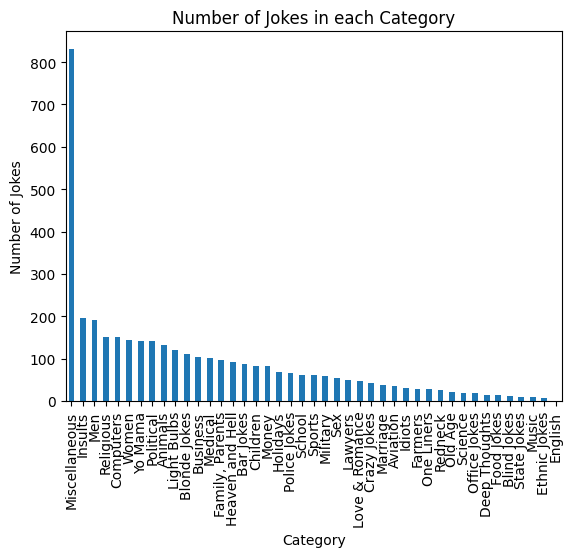

In [6]:
import matplotlib.pyplot as plt

# Count the number of jokes in each category
counts = df.category.value_counts()

# Create a bar chart
counts.plot(kind='bar')
plt.title('Number of Jokes in each Category')
plt.xlabel('Category')
plt.ylabel('Number of Jokes')

# Show the plot
plt.show()

Miscellaneous jokes are significantly more than other jokes. Therefore, it is better to drop them for now.

In [7]:
df = df[df['category'] != 'Miscellaneous']
df

,body,category,id,rating
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30
...,...,...,...,...
3653,,Religious,3654,3.00
3654,"At an interfaith retreat some time ago, the or...",Religious,3655,3.00
3655,,Religious,3656,2.00
3656,We have all learned to live with voice mail as...,Religious,3657,3.00


In [8]:
df['category'].value_counts()

Insults            196
Men                190
Religious          152
Computers          150
Women              144
Yo Mama            141
Political          141
Animals            131
Light Bulbs        120
Blonde Jokes       111
Business           104
Medical            101
Family, Parents     96
Heaven and Hell     91
Bar Jokes           87
Money               82
Children            82
Holidays            69
Police Jokes        67
School              62
Sports              61
Military            58
Sex                 54
Lawyers             50
Love & Romance      48
Crazy Jokes         43
Marriage            37
Aviation            35
Idiots              31
Farmers             29
One Liners          28
Redneck             27
Old Age             22
Science             18
Office Jokes        18
Deep Thoughts       14
Food Jokes          13
Blind Jokes         11
State Jokes         10
Music                9
Ethnic Jokes         8
English              1
Name: category, dtype: int64

We also need to drop the English category, too because when we split the data, the minimum number of groups for any class cannot be less than 2.

In [9]:
df = df[df['category'] != 'English']
df

,body,category,id,rating
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30
...,...,...,...,...
3653,,Religious,3654,3.00
3654,"At an interfaith retreat some time ago, the or...",Religious,3655,3.00
3655,,Religious,3656,2.00
3656,We have all learned to live with voice mail as...,Religious,3657,3.00


In [10]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Children': 0,
 'Blonde Jokes': 1,
 'Military': 2,
 'Office Jokes': 3,
 'Aviation': 4,
 'Political': 5,
 'Deep Thoughts': 6,
 'Men': 7,
 'Crazy Jokes': 8,
 'Medical': 9,
 'Food Jokes': 10,
 'Bar Jokes': 11,
 'Science': 12,
 'Police Jokes': 13,
 'Sex': 14,
 'Idiots': 15,
 'Business': 16,
 'Women': 17,
 'Redneck': 18,
 'One Liners': 19,
 'Money': 20,
 'School': 21,
 'Family, Parents': 22,
 'Sports': 23,
 'Heaven and Hell': 24,
 'Religious': 25,
 'Farmers': 26,
 'Love & Romance': 27,
 'Blind Jokes': 28,
 'Marriage': 29,
 'Old Age': 30,
 'Animals': 31,
 'Holidays': 32,
 'Ethnic Jokes': 33,
 'State Jokes': 34,
 'Computers': 35,
 'Lawyers': 36,
 'Yo Mama': 37,
 'Insults': 38,
 'Light Bulbs': 39,
 'Music': 40}

In [11]:
df['label'] = df.category.replace(label_dict)
df

/var/folders/ps/gtpc0wkx1j12zfc6gjn0kwsw0000gn/T/ipykernel_60639/3535961571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.category.replace(label_dict)


,body,category,id,rating,label
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63,0
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57,1
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09,1
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10,1
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30,1
...,...,...,...,...,...
3653,,Religious,3654,3.00,25
3654,"At an interfaith retreat some time ago, the or...",Religious,3655,3.00,25
3655,,Religious,3656,2.00,25
3656,We have all learned to live with voice mail as...,Religious,3657,3.00,25


#### Train and Validation Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=df.label.values)
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['category', 'label', 'data_type']).count()

/var/folders/ps/gtpc0wkx1j12zfc6gjn0kwsw0000gn/T/ipykernel_60639/520330715.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_type'] = ['not_set']*df.shape[0]


body   id  rating
category    label data_type                   
Animals     31    train       105  105     105
                  val          26   26      26
Aviation    4     train        28   28      28
                  val           7    7       7
Bar Jokes   11    train        69   69      69
...                           ...  ...     ...
State Jokes 34    val           2    2       2
Women       17    train       115  115     115
                  val          29   29      29
Yo Mama     37    train       113  113     113
                  val          28   28      28

[82 rows x 3 columns]

#### BertTokenizer and encoding the data

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [14]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/rishab/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(2352, 589)

In [16]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/Users/rishab/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [20]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [21]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [23]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [24]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/784 [00:00<?, ?it/s]


Epoch 1
Training loss: 3.203752554192835
Validation loss: 2.7322785824083433
F1 Score (Weighted): 0.25199534492522296


Epoch 2:   0%|          | 0/784 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.501706083989417
Validation loss: 2.3457399146432802
F1 Score (Weighted): 0.37706218370622985


Epoch 3:   0%|          | 0/784 [00:00<?, ?it/s]


Epoch 3
Training loss: 2.1426306399421726
Validation loss: 2.17644752187626
F1 Score (Weighted): 0.40046742986173567


Epoch 4:   0%|          | 0/784 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.91782502268384
Validation loss: 2.107169925882883
F1 Score (Weighted): 0.42434021159720076


Epoch 5:   0%|          | 0/784 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.7791117990522511
Validation loss: 2.080146233763943
F1 Score (Weighted): 0.4314936330467764


In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: Children
Accuracy: 5/16

Class: Blonde Jokes
Accuracy: 19/22

Class: Military
Accuracy: 0/12

Class: Office Jokes
Accuracy: 0/4

Class: Aviation
Accuracy: 0/7

Class: Political
Accuracy: 9/28

Class: Deep Thoughts
Accuracy: 0/3

Class: Men
Accuracy: 31/38

Class: Crazy Jokes
Accuracy: 0/9

Class: Medical
Accuracy: 0/20

Class: Food Jokes
Accuracy: 0/3

Class: Bar Jokes
Accuracy: 0/18

Class: Science
Accuracy: 0/4

Class: Police Jokes
Accuracy: 0/13

Class: Sex
Accuracy: 0/11

Class: Idiots
Accuracy: 0/6

Class: Business
Accuracy: 0/21

Class: Women
Accuracy: 3/29

Class: Redneck
Accuracy: 0/5

Class: One Liners
Accuracy: 0/6

Class: Money
Accuracy: 1/16

Class: School
Accuracy: 0/12

Class: Family, Parents
Accuracy: 0/19

Class: Sports
Accuracy: 0/12

Class: Heaven and Hell
Accuracy: 0/18

Class: Religious
Accuracy: 8/31

Class: Farmers
Accuracy: 0/6

Class: Love & Romance
Accuracy: 0/10

Class: Blind Jokes
Accuracy: 0/2

Class: Marriage
Accuracy: 0/7

Class: Old Age
Accuracy: 0